# Q-function Approximation

input : State <br>
output : Q-value(right,left,up,down) -> **all action**<br>
y_label = Q, Ws = Q_prediction

$$cost(W) =  (Ws-y)^2$$

$$ y = r + \gamma max Q(s`) $$
$$\hat Q(s,a|\theta) = Q^*(s,a)$$

### But Is Q* converges?
 No!, diverges using neural networds due to
 * Correlations between samples
 * Non-stationary targets

Input = One-Hot-incoding
```python
def one_hot(x):
  np.identity(16)[x:x+1]
```


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# FrozenLake-v0

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Success rate: 0.024


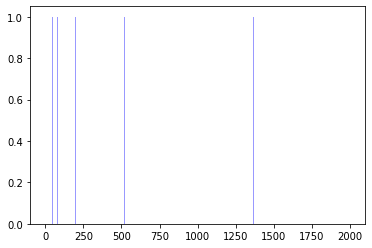

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf



env = gym.make('FrozenLake-v0')

# Input and output size based on the Env
input_size = env.observation_space.n;
output_size = env.action_space.n;
learning_rate = 0.1

# These lines establish the feed-forward part of the network used to choose actions
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)              # state input
W = tf.get_variable("w",shape=[input_size, output_size],
                    initializer = tf.contrib.layers.xavier_initializer())   # weight

Qpred = tf.matmul(X, W)     # Out Q prediction
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)    # Y label

loss = tf.reduce_sum(tf.square(Y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# Set Q-learning parameters
dis = .99
num_episodes = 2000

# create lists to contain total rewards and steps per episode
rList = []

def one_hot(x):
    return np.identity(16)[x:x+1]


init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in tqdm(range(num_episodes)):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # The Q-Table learning algorithm
        while not done:
            # Choose an action by greedly (with a chance of random action)
            # from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q, and no Qs+1, since it's a termial state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s` values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                # Update Q
                Qs[0, a] = reward + dis*np.max(Qs1)

            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1

        rList.append(rAll)

print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()



# CartPole-v0

In [ ]:
import gym
env = gym.make('CartPole-v0')
env.reset()
random_episodes = 0
reward_sum = 0

while random_episodes < 10:
  env.render()
  action = env.action_space.sample()
  s1,reward,done,_ = env.step(action)

  if done:
    Qs[0,a] = -100
  else:
    x1 = np.reshape(s1,[1,input_size])
    Qs1 = sess.run(Qpred,feed_dict={X:x1})
    Qs[0,a] = reward + dis*np.max(Qs1)

In [ ]:
env = gym.make('CartPole-v0')

# Constants defining our neural network
learning_rate = 1e-1
input_size = env.observation_space.shape[0];
output_size = env.action_space.n;

X = tf.placeholder(tf.float32, [None, input_size], name="input_x" )

# First layer of weights
W1 = tf.get_variable("W1", shape=[input_size, output_size], initializer=tf.contrib.layers.xavier_initializer() )   # weight

Qpred = tf.matmul(X, W1)

# We need to define the parts of the network needed for learning a policy
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)    # Y label

# Loss function
loss = tf.reduce_sum(tf.square(Y-Qpred))

# Learning
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Values for q-learning
dis = .99
num_episodes = 2000
rList = []

start_time = time.time()

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        e = 1. / ((i / 10) + 1)
        rAll = 0
        step_count = 0
        s = env.reset()
        done = False

        # The Q-Table learning algorithm
        while not done:
            step_count += 1
            x = np.reshape(s, [1, input_size])
            # Choose an action by greedly (with a chance of random action) from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: x})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q, and no Qs+1, since it's a termial state
                Qs[0, a] = -100
            else:
                x1 = np.reshape(s1, [1, input_size])
                # Obtain the Q_s` values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: x1})
                Qs[0, a] = reward + dis*np.max(Qs1)

            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: x, Y: Qs})
            s = s1

        rList.append(step_count)
        print("Episode: {} steps: {}".format(i, step_count))
        # If last 10's avg steps are 500, It's good enough
        if len(rList) > 10 and np.mean(rList[-10:]) > 500:
            break

    print("--- %s seconds ---" % (time.time() - start_time))

    # See our trained network in action
    observation = env.reset()
    reward_sum = 0
    while True:
        env.render()

        x = np.reshape(observation, [1, input_size])
        Qs = sess.run(Qpred, feed_dict={X: x})
        a = np.argmax(Qs)

        observation, reward, done, _ = env.step(a)
        reward_sum += reward
        if done:
            print("Total score: {}".format(reward_sum))
            break
